In [1]:
import re
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_style("ticks")


In [2]:
df = pd.read_csv('../data/metadata_with_tag.csv',
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str})

In [3]:
df_covid = df[df.tag_disease_covid19]

# Preprocessing

In [4]:
df['authors_list'] = df.authors.str.split(";")

In [5]:
author_papers = df.explode('authors_list')[['authors_list','sha']]
author_papers.columns = ['author_name','sha']
author_papers = author_papers.dropna()

In [6]:
author_papers.head(10)

,author_name,sha
0,"Madani, Tariq A",d1aafb70c066a2068b02786f8929fd9c900897fb
0,"Al-Ghamdi, Aisha A",d1aafb70c066a2068b02786f8929fd9c900897fb
1,"Vliet, Albert van der",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Eiserich, Jason P",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Cross, Carroll E",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
2,"Crouch, Erika C",06ced00a5fc04215949aa72528f2eeaae1d58927
3,"Fagan, Karen A",348055649b6b8cf2b9a376498df9bf41f7123605
3,"McMurtry, Ivan F",348055649b6b8cf2b9a376498df9bf41f7123605
3,"Rodman, David M",348055649b6b8cf2b9a376498df9bf41f7123605
4,"Domachowske, Joseph B",5f48792a5fa08bed9f56016f4981ae2ca6031b32


## Generalize Names

In [7]:
author_papers['author_name'] = author_papers['author_name'].str.replace(" ", "").str.replace(".","").str.replace(',',', ')

In [8]:
from mlxtend.text import generalize_names

In [9]:
unqiue_count =[]
for letters in range(1,20,2):
    unqiue_count.append(
        len(
            author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=letters))
            .unique()))

KeyboardInterrupt: 

In [ ]:
sns.lineplot(list( range(1,20,2)), unqiue_count)

In [10]:
author_papers['author_name'] = author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=5))

In [11]:
author_papers['author_name'].str.len().describe(percentiles=[.85,.9,.95,0.99,0.995,0.999,0.9995])

count     1.218020e+06
mean      1.094845e+01
std       3.585698e+00
min       0.000000e+00
50%       1.100000e+01
85%       1.400000e+01
90%       1.500000e+01
95%       1.700000e+01
99%       2.100000e+01
99.5%     2.200000e+01
99.9%     2.500000e+01
99.95%    2.600000e+01
max       9.800000e+01
Name: author_name, dtype: float64

In [12]:
author_papers = author_papers[(author_papers['author_name'].str.len() <= 25) 
                              & (author_papers['author_name'].str.len() > 0) 
                              & (author_papers['sha'] != False)
                              & (author_papers['author_name'] != 'false')]

author_papers['author_name'] = author_papers['author_name'].apply(lambda x:x.title())
author_papers.to_csv('../data/author_papers.csv',index=False)

In [14]:
covid_paper = list(df_covid.sha.unique())
covid_author_paper = author_papers[author_papers.sha.isin(covid_paper)][['author_name','sha']]

# EDA

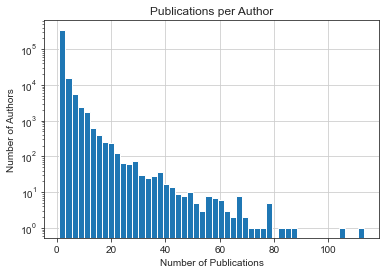

In [15]:
plt.title('Publications per Author')
plt.xlabel('Number of Publications')
plt.ylabel('Number of Authors')
covid_author_paper.groupby('author_name')['sha'].count().hist(bins=50,log=True)
plt.savefig('./pic/author_papers_hist.pdf')

In [16]:
covid_author_paper.groupby('author_name')['sha'].count().describe(percentiles=[0.75,0.9,0.95,0.99])

count    365136.000000
mean          1.701673
std           2.107762
min           1.000000
50%           1.000000
75%           2.000000
90%           3.000000
95%           4.000000
99%          10.000000
max         113.000000
Name: sha, dtype: float64

In [17]:
len(covid_author_paper.author_name.unique())

365136

In [18]:
author_paper_cnt = covid_author_paper.groupby('author_name')['sha'].count()
author_paper_cnt.name = 'paper_count'
filtered_author_index = author_paper_cnt[author_paper_cnt >= 10].index.to_list()
len(filtered_author_index)

3822

In [19]:
filtered_author_papers = covid_author_paper[covid_author_paper['author_name'].isin(filtered_author_index)]

In [20]:
len(filtered_author_papers)

61223

# Build Network

In [21]:
paper_dict = dict(enumerate(list(filtered_author_papers['sha'].unique())))
paper_dict = {v:k for k,v in paper_dict.items()}

In [22]:
author_dict = dict(enumerate(list(filtered_author_papers['author_name'].unique())))
author_dict = {v:k for k,v in author_dict.items()}

In [23]:
author_paper_tuple = list(zip(filtered_author_papers['author_name'], filtered_author_papers['sha']))

In [24]:
author_paper_tuple = [(author_dict[author], paper_dict[paper])for author, paper in author_paper_tuple]

In [25]:
from scipy.sparse import csc_matrix,lil_matrix

In [26]:
#AP[i,j] = 1 indicates that author i published paper j
AP = csc_matrix((np.ones(len(author_paper_tuple)), zip(*author_paper_tuple)))
##AA[i,j] = 1 indicates that author i published a paper with author j
AA = AP.dot(AP.T)

In [27]:
AA

<3822x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 106332 stored elements in Compressed Sparse Column format>

In [28]:
AA = AA.tolil()
AA.setdiag(0)

In [29]:
AA

<3822x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 102510 stored elements in List of Lists format>

In [43]:
#construct graph
G = nx.convert_matrix.from_scipy_sparse_matrix(AA)

# Network Analysis

In [44]:
degree = nx.degree(G)
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=3000)

In [45]:
df_author = pd.DataFrame(author_dict.items())
df_author.columns= ['name','id']

In [46]:
df_author['degree'] = df_author['id'].apply(lambda x:degree[x])
df_author['degree_centrality'] = df_author['id'].apply(lambda x:degree_centrality[x])
df_author['eigenvector_centrality'] = df_author['id'].apply(lambda x:eigenvector_centrality[x])

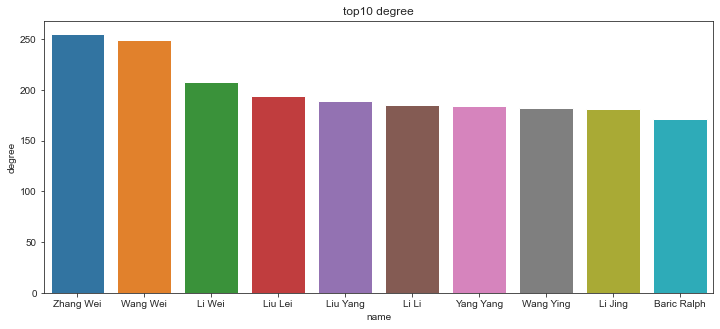

In [47]:
plt.figure(figsize=(12, 5))
plt.title('top10 degree')
sns.barplot(data=df_author.sort_values('degree',ascending=False)[:10], 
            x='name', y='degree')
plt.savefig('pic/top_10_degree.pdf')

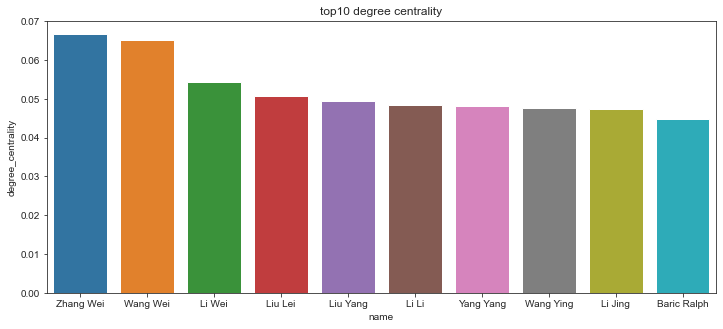

In [48]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('degree_centrality',ascending=False)[:10], 
            x='name', y='degree_centrality')
plt.savefig('pic/top_10_degree_centrality.pdf')

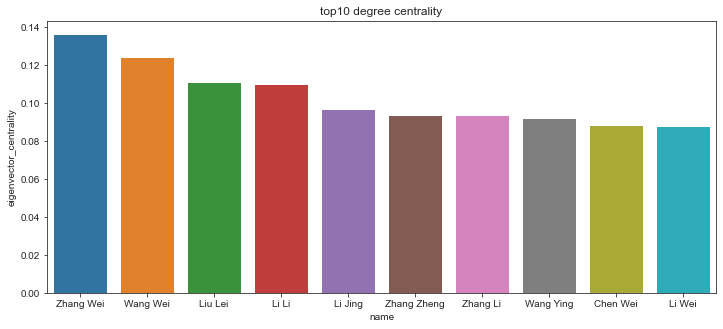

In [49]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('eigenvector_centrality',ascending=False)[:10], 
            x='name', y='eigenvector_centrality')
plt.savefig('pic/top_10_eigen_centrality.pdf')

# Community Detection

In [50]:
import community as community_louvain

In [51]:
partition = community_louvain.best_partition(G)

In [52]:
df_author['partition'] = df_author['id'].apply(lambda x:partition[x])

In [53]:
df_author = pd.merge(left=df_author, right= author_paper_cnt,how='left',left_on='name',right_on='author_name')
df_author_sampled = df_author[df_author.paper_count >= 10]
sampled_id = df_author_sampled.id.to_list()

In [54]:
df_author

,name,id,degree,degree_centrality,eigenvector_centrality,partition,paper_count
0,Zhang Sheng,0,73,0.019105,0.038838,0,45
1,Chen Decha,1,39,0.010207,0.020942,0,14
2,Wang Li,2,122,0.031929,0.054696,0,45
3,Zhao Shi,3,30,0.007851,0.007378,1,45
4,Cao Peihu,4,16,0.004187,0.001835,1,16
...,...,...,...,...,...,...,...
3817,Shrihari Swath,3817,30,0.007851,0.003428,18,10
3818,Wang Yibin,3818,42,0.010992,0.018323,25,12
3819,Lin Sheng,3819,8,0.002094,0.002516,0,12
3820,Benvenuto Domen,3820,5,0.001309,0.000024,4,12


In [55]:
top5_community = list(df_author.groupby(partition).id.count().sort_values(ascending=False)[:5].index)

In [56]:
print(
    df_author[
    df_author.partition.isin(top5_community)].groupby(partition).apply(
    lambda x: x.nlargest(3, 'paper_count')).reset_index()[['name','partition']].groupby('partition')['name'].apply(list).to_latex()
)

\begin{tabular}{ll}
\toprule
{} &                                           name \\
partition &                                                \\
\midrule
0         &                 [Wang Wei, Zhang Wei, Liu Lei] \\
3         &                        [Zhang Y, Wang Y, Li Y] \\
4         &  [Zumla Alimu, Ippolito Giuse, Bassetti Matte] \\
18        &         [Liu Yang, Baric Ralph, Krammer Flori] \\
112       &       [Lee Chang, Drosten Chris, Ciesek Sandr] \\
\bottomrule
\end{tabular}



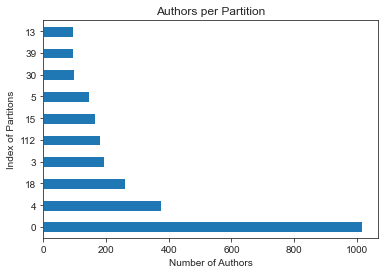

In [57]:
plt.title('Authors per Partition' )
plt.xlabel('Number of Authors')
plt.ylabel('Index of Partitons')
df_author.groupby(partition).id.count().sort_values(ascending=False)[:10].plot(kind='barh')
plt.savefig('./pic/author_per_partition.pdf')

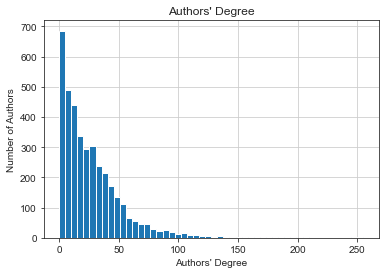

In [58]:
plt.title('Authors\' Degree' )
plt.xlabel('Authors\' Degree')
plt.ylabel('Number of Authors')
df_author['degree'].hist(bins=50)
plt.savefig('./pic/author_degree.svg')

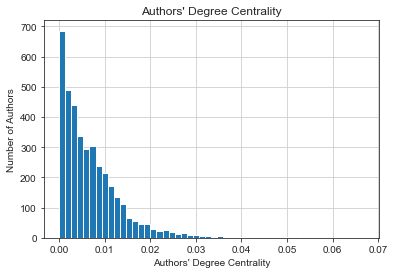

In [59]:
plt.title('Authors\' Degree Centrality' )
plt.xlabel('Authors\' Degree Centrality')
plt.ylabel('Number of Authors')
df_author['degree_centrality'].hist(bins=50)
plt.savefig('./pic/author_degree_centrality.svg')

In [275]:
modularity_dict = {}
adj_mat = nx.adjacency_matrix(G)
from sklearn.cluster import SpectralClustering
for n_clusters in np.linspace(50,500,10):
    n_clusters = int(n_clusters)
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)
    partitions_temp = sc.labels_
    partitions_temp = {i:label for i, label in enumerate(partitions_temp)}
    modularity_temp = community_louvain.modularity(partitions_temp, G)
    modularity_dict[n_clusters] = modularity_temp

/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, 

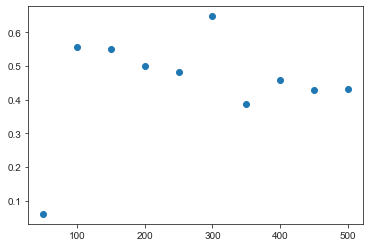

In [277]:
plt.scatter(modularity_dict.keys(), modularity_dict.values())

In [278]:
modularity_dict

{50: 0.06048425985655537,
 100: 0.5555917329196325,
 150: 0.5514632146550708,
 200: 0.49845788408735126,
 250: 0.48063667110888475,
 300: 0.6477007255319288,
 350: 0.388271479580823,
 400: 0.45691771037435897,
 450: 0.42808372854628596,
 500: 0.43058688102598736}

# TODO
1. Visualization
2. Other metrics 
3. Other algorithms 
4. With paper topic model

In [314]:
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput, WheelZoomTool, NodesAndLinkedEdges, NodesOnly
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [42]:
# Prepare Data
G = nx.karate_club_graph()

SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("club", "@club")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)


In [252]:
df_author['size'] = df_author['degree'].apply(lambda x: 4 * int(np.log(x)) if x > 0 else 0)

In [253]:
df_author['size'].describe()

count    3822.000000
mean        9.176347
std         4.466138
min         0.000000
25%         8.000000
50%         8.000000
75%        12.000000
max        20.000000
Name: size, dtype: float64

In [254]:
node_attr = df_author[['name','degree','paper_count','partition','size']].to_dict(orient='index')

In [255]:
nx.set_node_attributes(G,values=node_attr)

In [256]:
SAME_PARTITION_COLOR, DIFFEREENT_PARTITION_COLOR = "black", "red"

In [257]:
for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["partition"] == G.nodes[end_node]["partition"] else DIFFERENT_CLUB_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

In [258]:
nx.set_edge_attributes(G, edge_attrs, 'edge_color')

In [266]:
sub_nodes = [n for n in dict(degree) if dict(degree)[n] > 2]
G_sub = G.subgraph(sub_nodes)

In [295]:
plot = Plot(plot_width=1200, plot_height=850,
            x_range=Range1d(-6.1, 6.1), y_range=Range1d(-6.1, 6.1))
plot.title.text = "Author Network"
node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("degree", "@degree"), ('paper count', "@paper_count"),('partition',"@partition")])
plot.add_tools(node_hover_tool,WheelZoomTool(), BoxZoomTool(), ResetTool())

In [296]:
graph_renderer = from_networkx(G_sub, nx.spring_layout, scale=10, center=(0, 0))

In [310]:
nodes_partition = [G_sub.nodes[n]['partition'] for n in G_sub.nodes()]
partition_color = {j:i for i,j in enumerate(set(nodes_partition))}
nodes_color = [partition_color[i] for i in nodes_partition]

In [311]:
graph_renderer.node_renderer.data_source.data['color'] = nodes_color
nodes_fill_color = linear_cmap('color', 'Spectral8', min(nodes_color), max(nodes_color))
graph_renderer.node_renderer.glyph = Circle(size='size', fill_color=nodes_fill_color)
graph_renderer.node_renderer.selection_glyph = Circle(size='size', fill_color='white', line_width=2)
graph_renderer.node_renderer.hover_glyph = Circle(size='size', fill_color='white', line_width=2)



In [315]:
graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.1, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color='black',line_alpha=0.3, line_width=2)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color='black',line_alpha=0.3, line_width=2)

graph_renderer.selection_policy = NodesOnly()
graph_renderer.inspection_policy = NodesOnly()

In [316]:
plot.renderers.append(graph_renderer)

output_file("author.html")
show(plot)

{'field': 'color', 'transform': LinearColorMapper(id='7016', ...)}